Реализация Vision Transformer по <a href="https://arxiv.org/pdf/2010.11929.pdf">статье</a>. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
from tensorflow import keras

<img src="https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif">

While the Transformer architecture has become the de-facto standard for natural language processing tasks, its applications to computer vision remain limited. In vision, attention is either applied in conjunction with convolutional networks, or used to replace certain components of convolutional networks while keeping their overall structure in place. We show that this reliance on CNNs is not necessary and a pure transformer applied directly to sequences of image patches can perform very well on image classification tasks. When pre-trained on large amounts of data and transferred to multiple mid-sized or small image recognition benchmarks (ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() #keras.datasets.cifar100.load_data() 

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


Для начала напишем класс разбиения изображения на патчи (маленькие фрагменты).

In [8]:
class PatchEmbedding(tf.keras.layers.Layer):
  def __init__(self , size , num_of_patches , projection_dim):
    super().__init__()

    self.size=size
    self.num_of_patches= num_of_patches + 1
    self.projection_dim=projection_dim

    self.projection=tf.keras.layers.Dense(projection_dim)

    self.clsToken= tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)
    #create vector for each patch 
    self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)


  def call(self, inputs):
    patches = tf.image.extract_patches(inputs , 
                                       sizes=[1 , self.size , self.size , 1], 
                                       strides=[1 , self.size , self.size , 1], 
                                       rates=[1 ,1 ,1 ,1], 
                                       padding="VALID",)
    patches=tf.reshape(patches, (tf.shape(inputs)[0], -1, self.size * self.size *3))
    patches= self.projection(patches)

    # repeat cls token length of batch size
    clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)
    patches = tf.concat((clsToken, patches) , axis=1)
    # create position number for each patch
    positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
    positionalEmbedding = self.positionalEmbedding(positions)

    #print(positionalEmbedding)
    patches= patches + positionalEmbedding
    return patches


In [9]:
class TransformerLayer(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.mha= tf.keras.layers.MultiHeadAttention(heads, d_model//heads , dropout=dropout_rate)

    self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.mlp = tf.keras.Sequential([
                                    tf.keras.layers.Dense(d_model * mlp_rate , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate),
                                    tf.keras.layers.Dense(d_model , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate)
    ])
  def call(self , inputs , training=True):
    out_1 = self.layernorm_1(inputs)
    out_1 = self.mha(out_1 , out_1 ,training=training)
    out_1 = inputs + out_1

    out_2= self.layernorm_2(out_1)
    out_2=self.mlp(out_2 , training=training)
    out_2 = out_1 + out_2

    return out_2


In [10]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
    super().__init__()

    self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]

  def call(self , inputs , training=True):
    x =inputs

    for layer in self.encoders:
      x = layer(x , training=training)

    return x


In [11]:
class ViT(tf.keras.Model):
  def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
    self.encoder = TransformerEncoder(d_model , heads , mlp_rate  ,num_layers , dropout_rate)

    self.prediction = tf.keras.Sequential([
                                           tf.keras.layers.Dropout(0.3),
                                           tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                           tf.keras.layers.Dropout(0.2),       
                                           tf.keras.layers.Dense(num_classes, activation="softmax")

                                           
  ])
  def call(self , inputs ,  training=True):
    patches = self.patchEmbedding(inputs)
    encoderResult = self.encoder(patches, training=training)

    clsResult = encoderResult[: , 0 , :]

    prediction = self.prediction(clsResult,
                                 training=training)
    return prediction


In [8]:
image_size=72
preprocessingModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
    ]
)
# Compute the mean and the variance of the training data for normalization.
preprocessingModel.layers[0].adapt(x_train)

augmentationModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)


In [5]:
def convert_to_dataset(data, batch_size, shuffle=False , augment=False):
  dataset = tf.data.Dataset.from_tensor_slices(data)
  dataset = dataset.map(lambda x , y: (preprocessingModel(x) [0] , y) , num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    dataset= dataset.shuffle(len(dataset))

  dataset = dataset.batch(batch_size , drop_remainder=True)

  if augment:
    dataset = dataset.map(lambda x , y: (augmentationModel(x , training=True) , y) , num_parallel_calls=tf.data.AUTOTUNE)

  return dataset.prefetch(tf.data.AUTOTUNE)


In [10]:
trainingData = convert_to_dataset((x_train , y_train) , 1024 , shuffle=True , augment=True)
valData = convert_to_dataset((x_test , y_test) , 1024 , shuffle=False , augment=False)

print(trainingData)
print(valData)


<PrefetchDataset element_spec=(TensorSpec(shape=(1024, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 1), dtype=tf.uint8, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(1024, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 1), dtype=tf.uint8, name=None))>


In [32]:
x_train.shape

(50000, 32, 32, 3)

In [11]:
def scheduler(epoch, lr):
    if epoch < 35:
        return lr
    else:
        if epoch % 2:
            return lr * tf.math.exp(-0.1)
        else:
            return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [12]:
vitClassifier = ViT(num_classes=10, patch_size=6, num_of_patches=144,
                d_model=128, heads=2, num_layers=4,
                mlp_rate=2, dropout_rate=0.1)

vitClassifier.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=[
      tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
  ],
)


In [13]:
history = vitClassifier.fit(trainingData , 
                            batch_size=1024 , 
                            validation_data=valData , 
                            epochs=100, 
                            callbacks=[callback]) #batch_size=1024


Epoch 1/100
48/48 [==============================] - 62s 1s/step - loss: 1.9906 - accuracy: 0.2598 - top-5-accuracy: 0.7874 - val_loss: 1.7248 - val_accuracy: 0.3525 - val_top-5-accuracy: 0.8684 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 55s 1s/step - loss: 1.7111 - accuracy: 0.3627 - top-5-accuracy: 0.8736 - val_loss: 1.5358 - val_accuracy: 0.4328 - val_top-5-accuracy: 0.9093 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 55s 1s/step - loss: 1.5458 - accuracy: 0.4360 - top-5-accuracy: 0.9071 - val_loss: 1.4467 - val_accuracy: 0.4778 - val_top-5-accuracy: 0.9209 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 55s 1s/step - loss: 1.4059 - accuracy: 0.4871 - top-5-accuracy: 0.9269 - val_loss: 1.2721 - val_accuracy: 0.5401 - val_top-5-accuracy: 0.9467 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 57s 1s/step - loss: 1.3201 - accuracy: 0.5187 - top-5-accuracy: 0.9396 - val_loss: 1.2272 - val_accuracy: 0.5620 - 

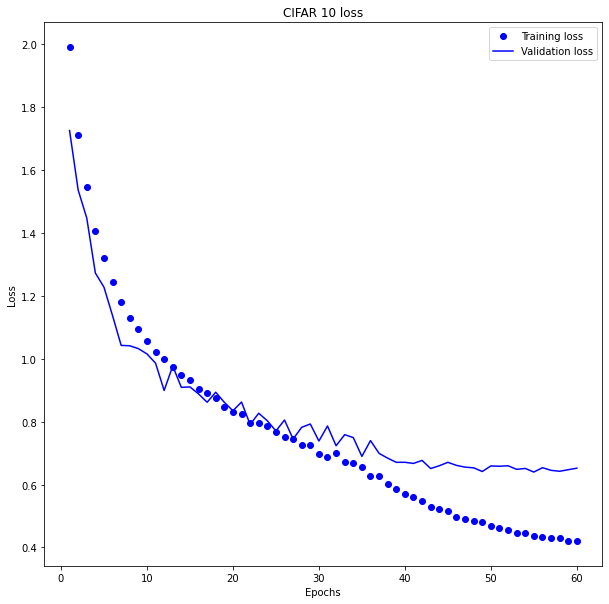

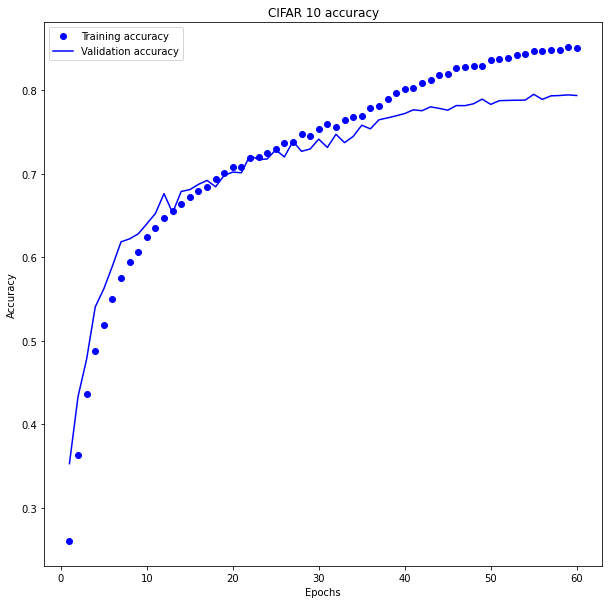

In [18]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy'][:60]) + 1)

plt.figure(figsize=(10,10))
plt.plot(epochs, history_dict['loss'][:60], 'bo', label = 'Training loss')
plt.plot(epochs, history_dict['val_loss'][:60], 'b', label = 'Validation loss')
plt.title('CIFAR 10 loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(epochs, history_dict['accuracy'][:60], 'bo', label = 'Training accuracy')
plt.plot(epochs, history_dict['val_accuracy'][:60], 'b', label = 'Validation accuracy')
plt.title('CIFAR 10 accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [19]:
_, accuracy, top_5_accuracy = vitClassifier.evaluate(valData)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


9/9 [==============================] - 2s 230ms/step - loss: 0.6493 - accuracy: 0.7951 - top-5-accuracy: 0.9891
Test accuracy: 79.51%
Test top 5 accuracy: 98.91%


In [17]:
def predict_sample(image_path):
    labels = {0:"airplane",1:"automobile",2:"bird",
              3:"cat", 4: "deer", 5: "dog", 
              6: "frog", 7: "horse", 8: "ship", 9: "truck"}
    image=tf.keras.preprocessing.image.load_img(image_path, target_size=(72 , 72))
    
    imageArray=tf.keras.preprocessing.image.img_to_array(image)
    imageArray = imageArray.reshape(1,72,72,3)
    label_idx = np.argmax(vitClassifier.predict(imageArray))
    print(labels[label_idx])
    return image

# CIFAR100

In [2]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data() 

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
image_size=72
preprocessingModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
    ]
)
preprocessingModel.layers[0].adapt(x_train)

augmentationModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

In [6]:
trainingData = convert_to_dataset((x_train , y_train) , 1024 , shuffle=True , augment=True)
valData = convert_to_dataset((x_test , y_test) , 1024 , shuffle=False , augment=False)

print(trainingData)
print(valData)

<PrefetchDataset element_spec=(TensorSpec(shape=(1024, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 1), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(1024, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 1), dtype=tf.int64, name=None))>


In [12]:
vitClassifier = ViT(num_classes=100,
                patch_size=6,
                num_of_patches=(72//6)**2,
                d_model=128,
                heads=4,
                num_layers=4,
                mlp_rate=2,
                dropout_rate=0.1
)

vitClassifier.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=[
      tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
  ],
)


In [13]:
def scheduler(epoch, lr):
    if epoch < 35:
        return lr
    else:
        if epoch // 2:
            return lr * tf.math.exp(-0.1)
        else:
            return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [14]:
history = vitClassifier.fit(trainingData , 
                            batch_size=1024 , 
                            validation_data=valData , 
                            epochs=60, 
                            callbacks=[callback]) #batch_size=1024


Epoch 1/60
48/48 [==============================] - 70s 1s/step - loss: 4.3322 - accuracy: 0.0475 - top-5-accuracy: 0.1690 - val_loss: 3.9660 - val_accuracy: 0.0871 - val_top-5-accuracy: 0.2793 - lr: 0.0010
Epoch 2/60
48/48 [==============================] - 59s 1s/step - loss: 3.8827 - accuracy: 0.0961 - top-5-accuracy: 0.2960 - val_loss: 3.5960 - val_accuracy: 0.1500 - val_top-5-accuracy: 0.3831 - lr: 0.0010
Epoch 3/60
48/48 [==============================] - 65s 1s/step - loss: 3.6039 - accuracy: 0.1391 - top-5-accuracy: 0.3824 - val_loss: 3.3149 - val_accuracy: 0.1933 - val_top-5-accuracy: 0.4696 - lr: 0.0010
Epoch 4/60
48/48 [==============================] - 62s 1s/step - loss: 3.3694 - accuracy: 0.1793 - top-5-accuracy: 0.4568 - val_loss: 3.0969 - val_accuracy: 0.2267 - val_top-5-accuracy: 0.5330 - lr: 0.0010
Epoch 5/60
48/48 [==============================] - 58s 1s/step - loss: 3.1818 - accuracy: 0.2132 - top-5-accuracy: 0.5060 - val_loss: 2.9511 - val_accuracy: 0.2598 - val_t

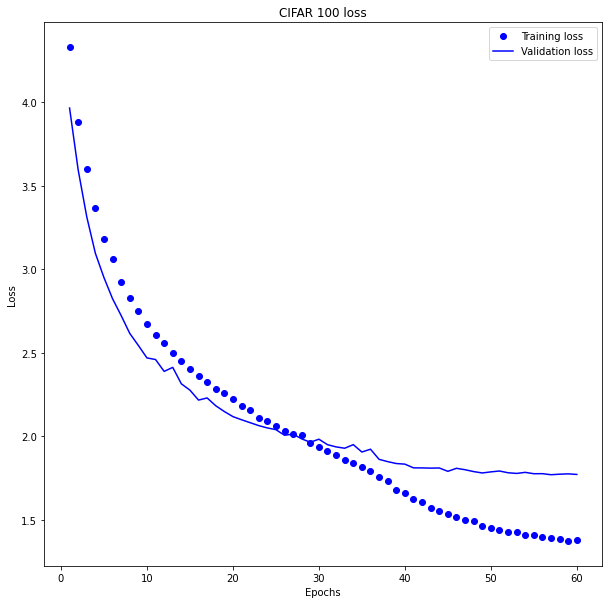

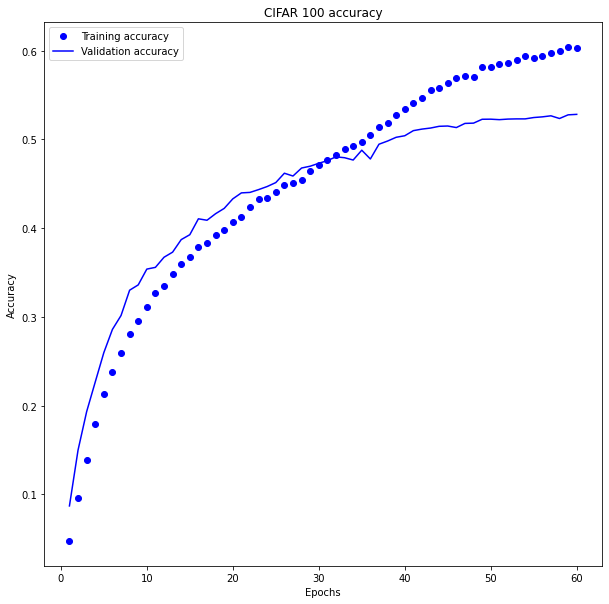

In [20]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy'][:60]) + 1)


plt.figure(figsize=(10,10))
plt.plot(epochs, history_dict['loss'][:60], 'bo', label = 'Training loss')
plt.plot(epochs, history_dict['val_loss'][:60], 'b', label = 'Validation loss')
plt.title('CIFAR 100 loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(epochs, history_dict['accuracy'][:60], 'bo', label = 'Training accuracy')
plt.plot(epochs, history_dict['val_accuracy'][:60], 'b', label = 'Validation accuracy')
plt.title('CIFAR 100 accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
_, accuracy, top_5_accuracy = vitClassifier.evaluate(valData)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

9/9 [==============================] - 3s 267ms/step - loss: 1.7724 - accuracy: 0.5281 - top-5-accuracy: 0.8212
Test accuracy: 52.81%
Test top 5 accuracy: 82.12%


automobile


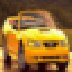

In [315]:
predict_sample('./automobile.png')

airplane


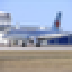

In [316]:
predict_sample('./airplane.png')

bird


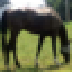

In [320]:
predict_sample('./horse.png')